In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib
import pickle
import sys
from lib import models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

font = {
    "family": "sans-serif",
    "weight": "bold",
    "size": 16
}
matplotlib.rc("font", **font)

In [2]:
# Read the data
dir_path = os.path.join(os.getcwd(), "results")
file_name = "segment_times_multi-class.xlsx"

# load all the data
segment_windows = [15, 30, 60, 120]
dfs = {}
for segment_window in segment_windows:
    dfs[segment_window] = pd.read_excel(os.path.join(dir_path, file_name), str(segment_window), index_col=0, header=[0, 1])

# Strip the white spaces at the end within the col names
for segment_window in segment_windows:
    cols = dfs[segment_window].columns
    new_cols = []
    for col in cols:
        temp1 = col[0].strip()
        temp2 = col[1].strip()
        new_cols.append((temp1, temp2))
    dfs[segment_window].columns = pd.MultiIndex.from_tuples(new_cols)

# Impact of the Window sizes
- The plot between different window sizes

## Plot on different window sizes

To determine which among the tried window sizes is the best

- For the study only the F1-Score is considered

Plotting the average of the F1-Score

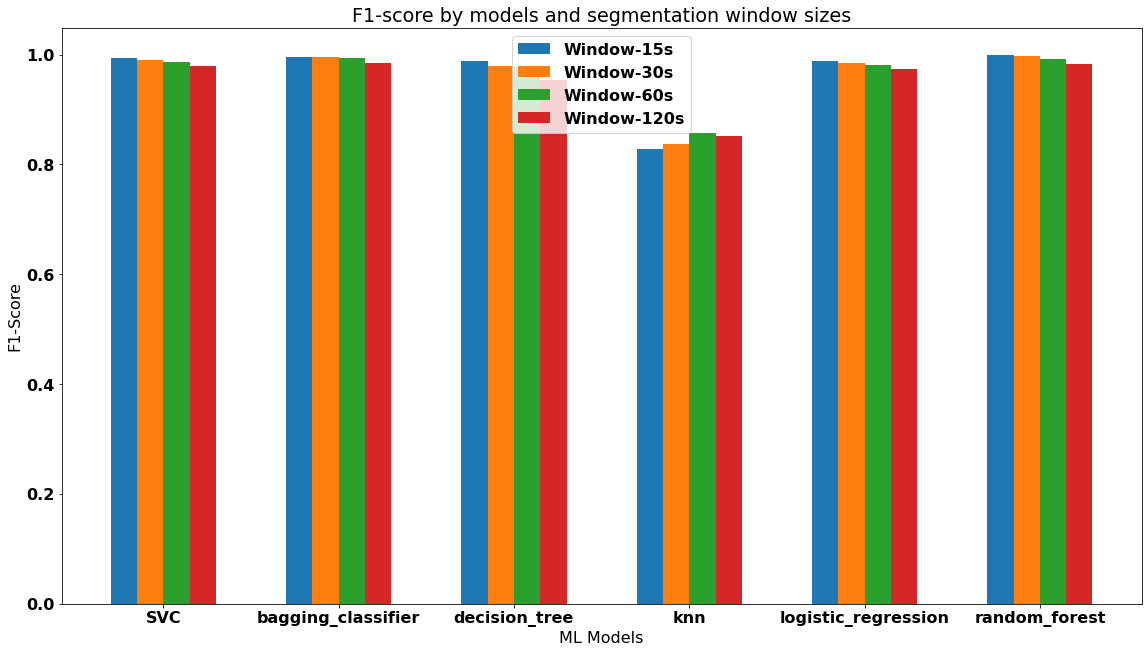

In [3]:
# Figure parameters
fig = plt.figure(figsize=(15, 8))
ax = fig.add_axes([0, 0, 1, 1])

# The models in the picture
labels = ["LogisticRegression", "DecisionTree", "k-NN", "SVC", "Bagging", "RandomForests"]
model_names_file = np.unique([x[0] for x in dfs[120].columns]).tolist()
x = np.arange(len(model_names_file))
width = 0.15
segment_vals_accuracy = {}
segment_vals_std = {}

for segment_window in segment_windows:
    segment_vals_accuracy[segment_window] = []
    segment_vals_std[segment_window] = []
    for model_name in model_names_file:
        segment_vals_accuracy[segment_window].append(dfs[segment_window][model_name]["score"].iloc[2])
        segment_vals_std[segment_window].append(dfs[segment_window][model_name]["std"].iloc[2])

# Plotting
ax.bar(x - 0.225, segment_vals_accuracy[15], width, label="Window-15s")
ax.bar(x - 0.075, segment_vals_accuracy[30], width, label="Window-30s")
ax.bar(x + 0.075, segment_vals_accuracy[60], width, label="Window-60s")
ax.bar(x + 0.225, segment_vals_accuracy[120], width, label="Window-120s")

# Set legends and labels
ax.set_ylabel("F1-Score")
ax.set_xlabel("ML Models")
ax.set_title("F1-score by models and segmentation window sizes")
ax.set_xticks(x)
ax.set_xticklabels(model_names_file)
ax.legend()


Plotting the Standard Deviation of the F1-Score

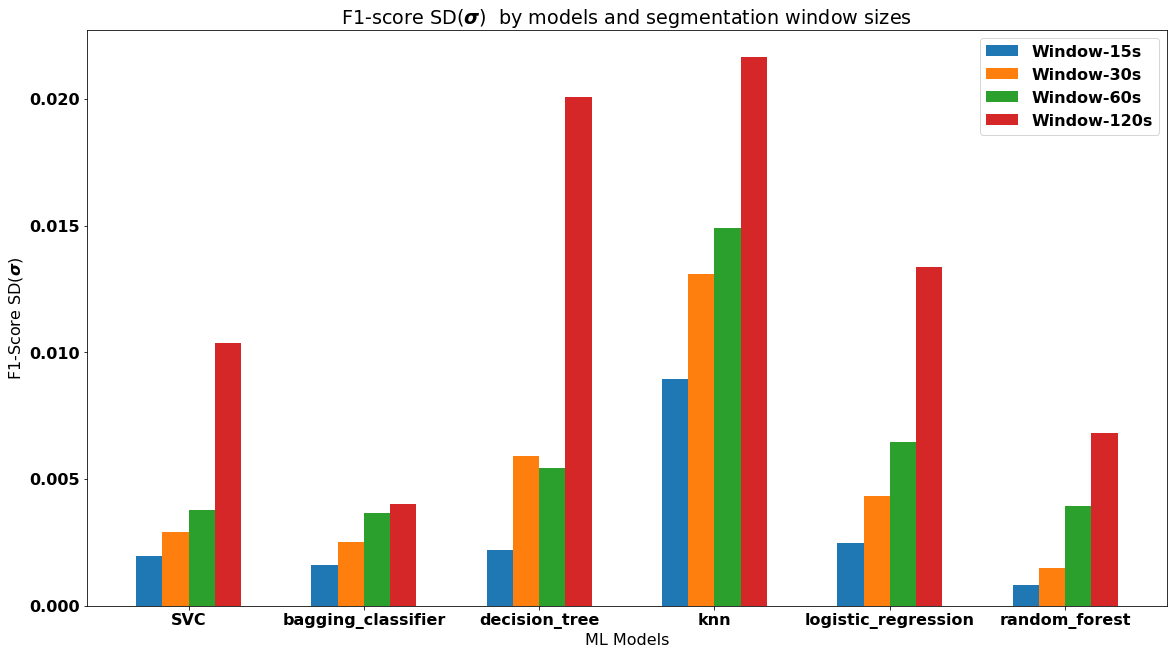

In [4]:
# Figure parameters
fig = plt.figure(figsize=(15, 8))
ax = fig.add_axes([0, 0, 1, 1])

# Plotting
ax.bar(x - 0.225, segment_vals_std[15], width, label="Window-15s")
ax.bar(x - 0.075, segment_vals_std[30], width, label="Window-30s")
ax.bar(x + 0.075, segment_vals_std[60], width, label="Window-60s")
ax.bar(x + 0.225, segment_vals_std[120], width, label="Window-120s")

# Set legends and labels
ax.set_ylabel("F1-Score SD($\sigma$)")
ax.set_xlabel("ML Models")
ax.set_title("F1-score SD($\sigma$)  by models and segmentation window sizes")
ax.set_xticks(x)
ax.set_xticklabels(model_names_file)
ax.legend()

Ideally the best window size would be 15s
- Highest prediction accuracy
- Lowest SD

---

The one that was chosen was the 60sec, because its performance was consistent



# Determine the confusion matrices

In [5]:
# Load the data
file_dir = os.path.join(os.getcwd(), "results")
file_name = "training_data.pkl"
with open(os.path.join(file_dir, file_name), "rb") as file_handle:
    train_data = pickle.load(file_handle)
X = train_data["X"]
y = train_data["y"]

sys.stdout.write(f"The shape of the loaded data is {X.shape}\n")

The shape of the loaded data is (6286, 153)


In [6]:
# Splitting into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Apply StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [7]:
# get the models
model_params = {'LogisticRegression': {'max_iter': 5000, 'multi_class': 'multinomial', 'n_jobs': 4, 'tol': 0.0001, "class_weight": "balanced"},
 'DecisionTreeClassifier': {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 100},
 'KNeighborsClassifier': {'n_neighbors': 20},
 'SVC': {'class_weight': 'balanced', 'kernel': 'linear', 'tol': 1e-07},
 'BaggingClassifier': {'n_estimators': 50},
 'RandomForestClassifier': {'class_weight': 'balanced', 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 100, 'n_estimators': 200}}

# Create repo of models
models_repo = models.Models()
# Initialize the models
models_repo.create_models(model_params)

In [8]:
# Training the model
models_repo.train_models(X_train, y_train, verbose=1)

|| Trained - LogisticRegression ||
|| Trained - DecisionTreeClassifier ||
|| Trained - KNeighborsClassifier ||
|| Trained - SVC ||
|| Trained - BaggingClassifier ||
|| Trained - RandomForestClassifier ||


In [9]:
# Make and store predictions
predictions = {}
for model_name in models_repo.trained_model_dict.keys():
    predictions[model_name] = models_repo.trained_model_dict[model_name].predict(X_test)

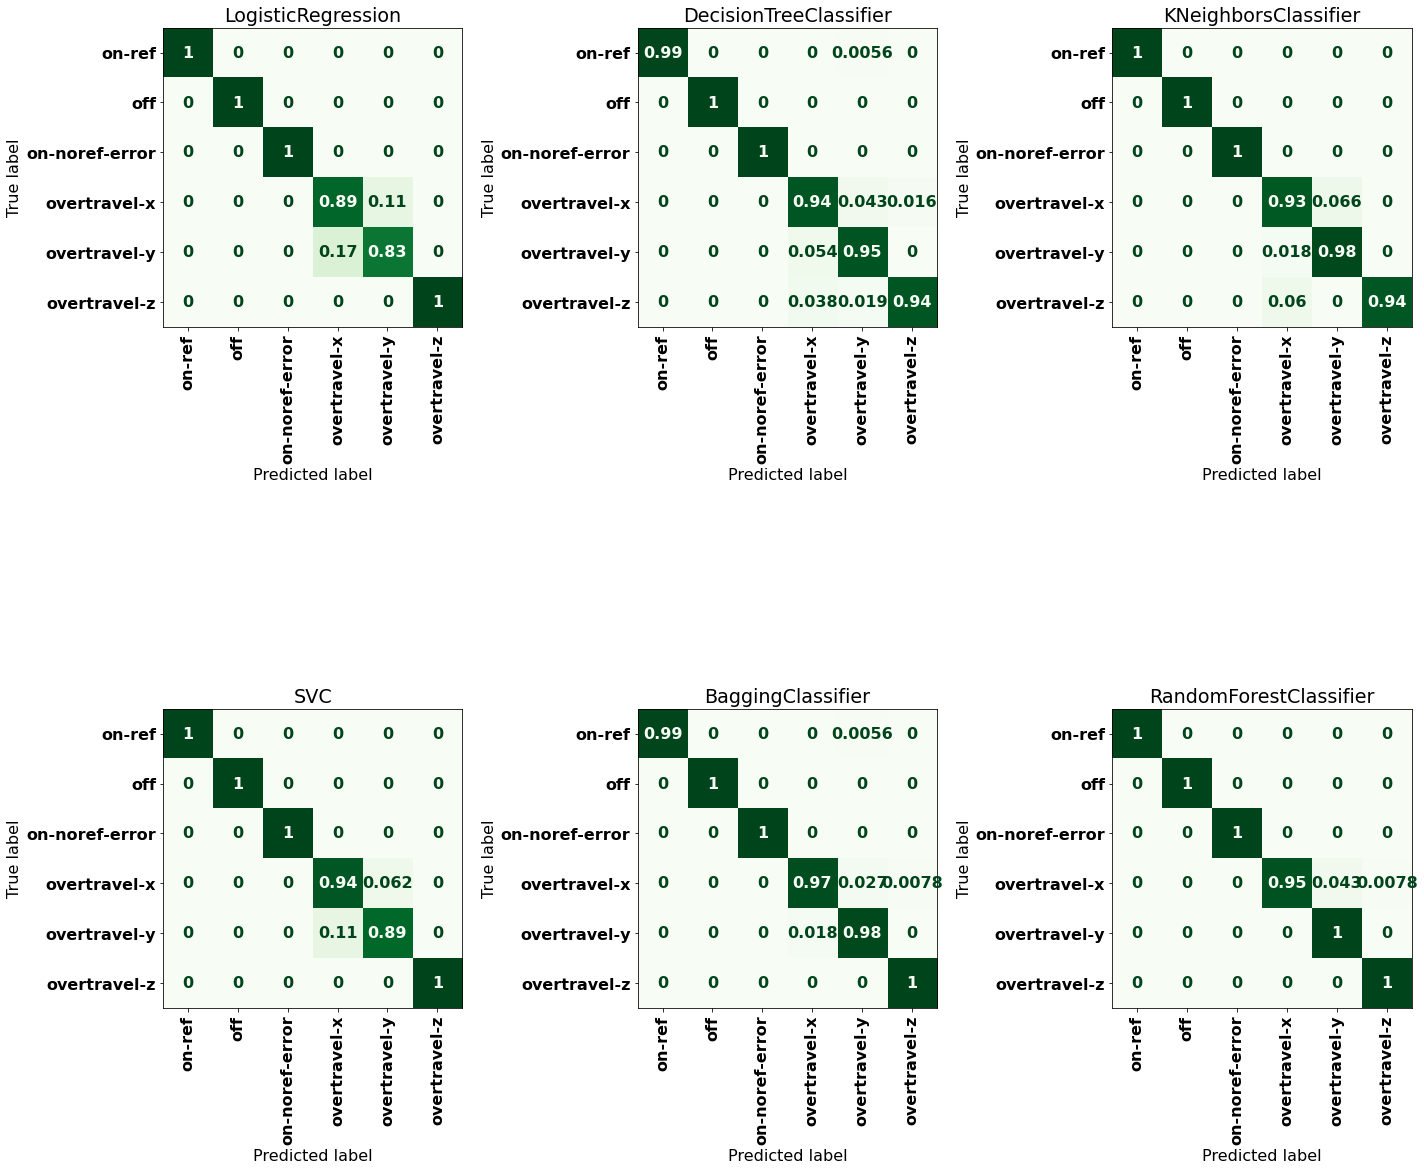

In [10]:
fig = plt.figure(figsize=(20, 20))
axs = fig.subplots(2, 3)

# Reset fonts
font = {
    "family": "sans-serif",
    "weight": "bold",
    "size": 16
}
matplotlib.rc("font", **font)

# Plot the matrices
model_names = list(predictions.keys())
index = 0
classes = ["on-ref", "off", "on-noref-error", "overtravel-x", "overtravel-y", "overtravel-z"]
for row in range(2):
    for col in range(3):
        cm = confusion_matrix(y_test, predictions[model_names[index]], normalize="true")
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
        disp.plot(cmap="Greens", ax=axs[row, col], xticks_rotation="vertical", colorbar=False)
        # Set the axs details
        axs[row, col].set_title(f"{model_names[index]}")
        index += 1

fig.tight_layout(pad=1.0)
